In [65]:
# load the package
include("../FractionalFlow/FractionalFlow.jl")
using PyPlot, SetPyPlot, NLopt, Dierckx
import Calculus
FF = FractionalFlow

FractionalFlow

# Water-flooding

0.6815945945945946

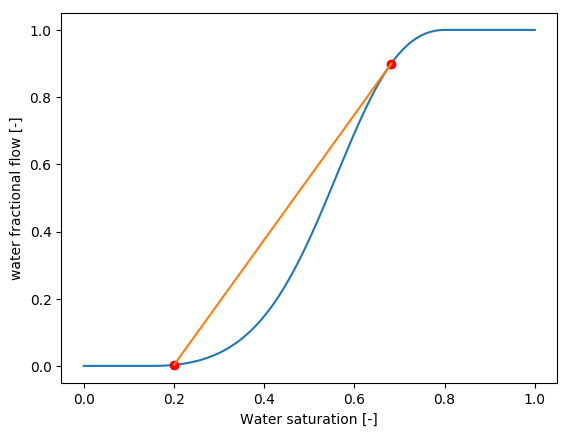

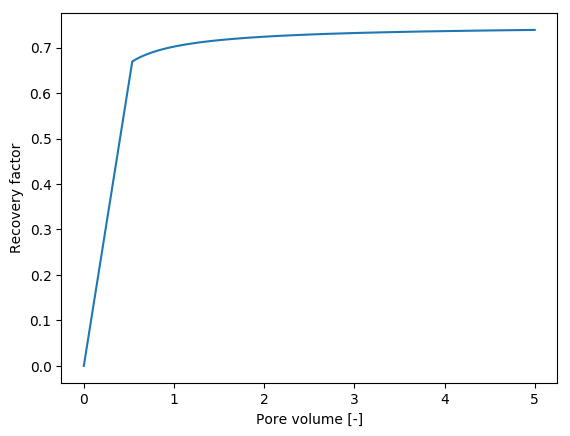

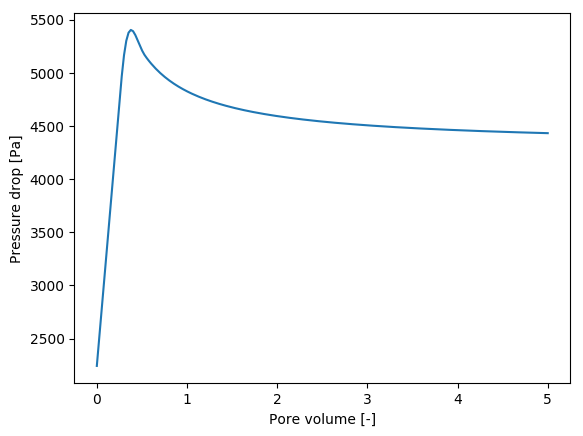

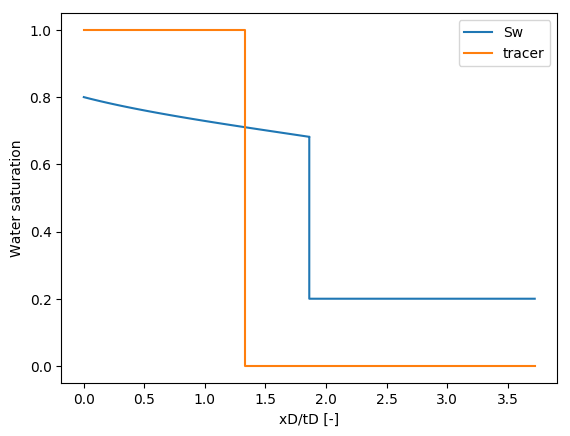


0.002223502807782718
5.551115123125783e-16
sw_shock = 0.6818181818181818
0.7101351351351352
0.003971787974491714
3.3306690738754696e-16


PyObject <matplotlib.legend.Legend object at 0x7f16fdab23d0>

In [66]:
# define the problem
# relative permeabilities
rel_perms = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
    swc=0.15, sor=0.2, nw=2.0, no = 2.0)
# FF.visualize(rel_perms)
# define the fluids
fluids = FF.oil_water_fluids(mu_water=1e-3, mu_oil=1e-3)

# define the fractional flow functions
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
# visualize the fractional flow
# FF.visualize(rel_perms, fluids, label="lowsal")
# tight_layout()
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=5, 
    p_back=1e5, sw_init=0.2, sw_inj=1.0, rel_perms=rel_perms)
core_props = FF.core_properties()
wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
sw_tmp = linspace(0,1,100)
# plot(sw_tmp, fw.(sw_tmp), xlabel = "Sw", ylabel="fw", label="")
# plot!(sw_tmp, dfw.(sw_tmp))
# figure(1)
# plot(pv, R) 
# xlabel("PV injected")
# ylabel("Recovery factor") 
# title("Water flooding")
# figure(2)
# plot(xt, sw)
# xlabel("x/t [-]")
# ylabel("Water saturation [-]")
FF.visualize(wf_res)

# synthetic experimental data


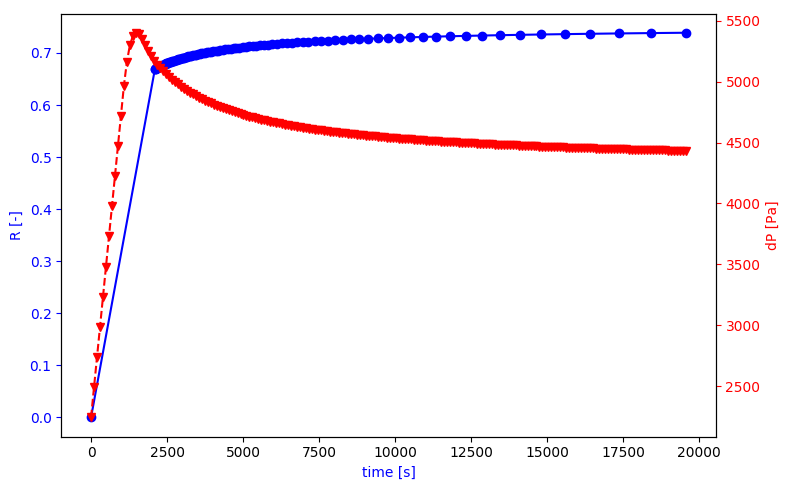

(PyPlot.Figure(PyObject <Figure size 800x500 with 2 Axes>), PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f16e2532790>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f16e3e5a590>)

In [67]:
t_exp_dp = wf_res.dp_time[:,1]
dp_exp = wf_res.dp_time[:,2]
t_exp_R = wf_res.recovery_time[:,1]
R_exp = wf_res.recovery_time[:,2]
plotyy(t_exp_R, R_exp, t_exp_dp, dp_exp, fig_size = [8,5], x_label="time [s]", y1_label="R [-]", y2_label="dP [Pa]")

# define the objective function

In [68]:
# struct
struct exp_data
    t_exp_dp
    dp_exp
    t_exp_R
    R_exp
end
exp_data1 = exp_data(t_exp_dp, dp_exp, t_exp_R, R_exp)

exp_data(Real[0.0, 98.3177, 196.635, 294.953, 393.271, 491.588, 589.906, 688.224, 786.541, 884.859  …  18680.4, 18778.7, 18877.0, 18975.3, 19073.6, 19171.9, 19270.3, 19368.6, 19466.9, 19565.2], Real[2242.5, 2490.44, 2738.38, 2986.32, 3234.26, 3482.21, 3730.15, 3978.09, 4226.03, 4473.97  …  4436.68, 4436.06, 4435.44, 4434.84, 4434.23, 4433.64, 4433.05, 4432.46, 4431.88, 4431.31], Real[0.0, 2102.05, 2102.05, 2123.61, 2145.64, 2168.16, 2191.17, 2214.69, 2238.73, 2263.31  …  12317.7, 12863.9, 13456.0, 14100.1, 14803.1, 15573.4, 16421.2, 17358.6, 18400.4, 19565.2], Real[0.0, 0.669421, 0.669421, 0.670104, 0.670788, 0.671473, 0.67216, 0.672849, 0.673539, 0.674231  …  0.732803, 0.733483, 0.734162, 0.734839, 0.735515, 0.736189, 0.736862, 0.737533, 0.738203, 0.738871])

In [69]:
"""
rel_perm_param [krw0, kro0, nw, no, swc, sor]
"""
function error_calc(rel_perm_param, exp_data, core_props, fluids, core_flood; w_p=1.0, w_R=1.0)
    rel_perms = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
    dp_calc = Spline1D(wf_res.dp_time[:,1], wf_res.dp_time[:,2], k=1)
    R_calc = Spline1D(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], k=1)
    error_dp = abs.(dp_calc(exp_data.t_exp_dp) .- exp_data.dp_exp)
    error_R = abs.(R_calc(exp_data.t_exp_R) .- exp_data.R_exp)
    error_dp_norm = w_p.*error_dp./maximum(error_dp)
    error_R_norm = w_R.*error_R./maximum(error_R)
    return mean(error_R_norm)+mean(error_dp_norm)
end

function vis_error(rel_perm_param, exp_data, core_props, fluids, core_flood)
    rel_perms = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
    figure()
    plot(wf_res.dp_time[:,1], wf_res.dp_time[:,2],  exp_data.t_exp_dp, exp_data.dp_exp, "o")
    xlabel("t [s]")
    ylabel("dp [Pa]")
    legend(["Theoretical", "Experiment"])
    
    figure()
    plot(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], exp_data.t_exp_R, exp_data.R_exp, "v")
    xlabel("t [s]")
    ylabel("R [-]")
    legend(["Theoretical", "Experiment"])
    
end

# test
x_init = [0.109681, 0.201297, 3.96653, 1.0003, 0.249277, 0.262231]
error_calc(x_init, exp_data1, core_props, fluids, core_flood)
vis_error(x_init, exp_data1, core_props, fluids, core_flood)

0.736769
0.5095090932934965
0.5095090932934965
sw_shock = 0.736769
0.736769
0.6426555494300884
0.6426555494300884


LoadError: [91mBoundsError: attempt to access 0-element Array{Int64,1} at index [1][39m

# define the objective function and gradients and weight factors

In [26]:
w_p = ones(length(exp_data1.dp_exp))
w_p[indmax(exp_data1.dp_exp)] = 5

function f(x)
    return error_calc(x, exp_data1, core_props, fluids, core_flood)
end

    
function g(x)
    return Calculus.gradient(x -> error_calc(x, exp_data1, core_props, fluids, core_flood), x)
end

function obj_fun(param, grad)
    if length(grad)>0
      grad[:] = g(param)
    end
    
    return f(param)
end

# test
grad_x = zeros(6)
obj_fun([1.0, 0.8, 3, 4, 0.2, 0.2], grad_x)

INFO: Outlet saturation is estimated: 0.6320048775417896, error is -0.0024908096051170503
INFO: Outlet saturation is estimated: 0.6320116264310502, error is -0.0025819255068117997


NaN

In [27]:
grad_x

6-element Array{Float64,1}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [28]:
x_init = [0.9, 0.8, 3, 3, 0.2, 0.2]
x_lb = [0.1, 0.1, 1.0, 1.0, 0.01, 0.01]
x_ub = [1.0, 1.0, 4.0, 4.0, 0.3, 0.3]
opt_alg=:LN_NELDERMEAD
opt1 = Opt(opt_alg, length(x_init)) # choose the algorithm
lower_bounds!(opt1, x_lb)
upper_bounds!(opt1, x_ub)
ftol_rel!(opt1, 1e-10)
ftol_abs!(opt1, 1e-10)

min_objective!(opt1, obj_fun)
(fObjOpt, paramOpt, flag) = optimize(opt1, x_init)

INFO: Outlet saturation is estimated: 0.6693854035689984, error is -0.0052119811848436726
INFO: Outlet saturation is estimated: 0.6851491751569301, error is -0.004935134607341851
INFO: Outlet saturation is estimated: 0.675957286451086, error is 0.011489225693461336
INFO: Outlet saturation is estimated: 0.6836159341474999, error is -0.013749466159361567
INFO: Outlet saturation is estimated: 0.682839490695054, error is -0.003247158154739971
INFO: Outlet saturation is estimated: 0.6825286368963838, error is 0.00020408561589935204
INFO: Outlet saturation is estimated: 0.6827980003601988, error is -0.002702290078966385
INFO: Outlet saturation is estimated: 0.6826425686876751, error is -0.0009764364527580227
INFO: Outlet saturation is estimated: 0.6827616884864334, error is -0.0022251503221957236
INFO: Outlet saturation is estimated: 0.6827422590050551, error is -0.0020093932628313382
INFO: Outlet saturation is estimated: 0.682772808821498, error is -0.0026523763443329074
INFO: Outlet satura

(NaN, [0.9, 0.8, 3.0, 3.0, 0.2, 0.2], :XTOL_REACHED)

In [29]:
x_init = [0.109681, 0.201297, 3.96653, 1.0003, 0.249277, 0.262231]
error_calc(x_init, exp_data1, core_props, fluids, core_flood)
vis_error(x_init, exp_data1, core_props, fluids, core_flood)

LoadError: [91mBoundsError: attempt to access 0-element Array{Int64,1} at index [1][39m

# Low-sal water flooding

# Low-sal water flooding with adsorption

In [30]:
find(rand(100).>0.8)[1]

5

# Fitting the rel-perm curves